In [3]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import joblib

import pandas as pd
import lightgbm as lgb

In [4]:
# read embedded text data

test_df_with_embeddings = pd.read_parquet("../data/40k__test_sampled_with_embeddings.parquet")
train_df_with_embeddings = pd.read_parquet("../data/40k__train_sampled_with_embeddings.parquet")

In [5]:
test_df_with_embeddings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              8000 non-null   int64 
 1   source          8000 non-null   object
 2   text            8000 non-null   object
 3   text_embedding  8000 non-null   object
 4   label           8000 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 312.6+ KB


In [6]:
train_df_with_embeddings.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              32000 non-null  int64 
 1   source          32000 non-null  object
 2   text            32000 non-null  object
 3   text_embedding  32000 non-null  object
 4   label           32000 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.2+ MB


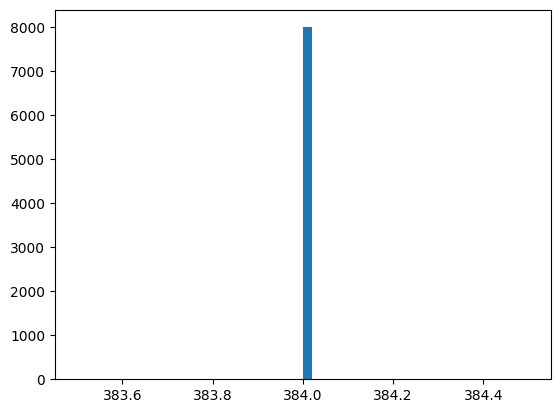

In [7]:
import matplotlib.pyplot as plt

plt.hist([len(text) for text in test_df_with_embeddings["text_embedding"]], bins=50)
plt.show()

In [8]:
train_df_with_embeddings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              32000 non-null  int64 
 1   source          32000 non-null  object
 2   text            32000 non-null  object
 3   text_embedding  32000 non-null  object
 4   label           32000 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.2+ MB


In [9]:
# prepare the data for training
train_X = train_df_with_embeddings["text_embedding"].to_list()
test_X = test_df_with_embeddings["text_embedding"].to_list()

train_Y = train_df_with_embeddings["label"].to_list()
test_Y = test_df_with_embeddings["label"].to_list()

train_ids = train_df_with_embeddings["id"].to_list()
test_ids = test_df_with_embeddings["id"].to_list()


In [10]:
# train with lgbm classifier

lgb_model = Pipeline(
    [
        ("scaler", StandardScaler()),  # Standardize the embeddings
        ("classifier", lgb.LGBMClassifier()),  # LightGBM classifier
    ]
)

# Define the parameter grid
param_grid = {
    "classifier__num_leaves": [31, 63, 127, 255],  # Lower values for simpler models
    "classifier__learning_rate": [0.05],  # Range from conservative to standard rates
    "classifier__n_estimators": [200],  # Number of boosting rounds
    "classifier__max_depth": [-1, 10, 20],  # -1 means no limit; otherwise fixed depth
}


# intialize lgm grid search
lgb_grid = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    scoring="recall",  # Use 'roc_auc' or other metrics if appropriate for the task
    cv=3,  # 3-fold cross-validation to reduce computation time
    n_jobs=-1,  # Use all available CPU cores
    verbose=3,  # To monitor progress
)



In [11]:
# Fit the grid search to the data (assuming X_train and y_train are defined)
lgb_grid.fit(train_X, train_Y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[LightGBM] [Info] Number of positive: 10667, number of negative: 10666
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97920
[LightGBM] [Info] Number of data points in the train set: 21333, number of used features: 384
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500023 -> initscore=0.000094
[LightGBM] [Info] Start training from score 0.000094
[LightGBM] [Info] Number of positive: 10666, number of negative: 10667
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97920
[LightGBM] [Info] Number of data points in the train set: 21333, number of used features: 384
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499977 -> initscore=-0.000094
[Li

/Users/seifmostafa/.pyenv/versions/3.11.10/envs/llm_guard/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Number of positive: 16000, number of negative: 16000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97920
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 384
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', LGBMClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.05],
                         'classifier__max_depth': [-1, 10, 20],
                         'classifier__n_estimators': [200],
                         'classifier__num_leaves': [31, 63, 127, 255]},
             scoring='recall', verbose=3)

In [12]:
# Print the best parameters and best score
print("Best parameters found: ", lgb_grid.best_params_)
print("Best cross-validation accuracy: ", lgb_grid.best_score_)

Best parameters found:  {'classifier__learning_rate': 0.05, 'classifier__max_depth': -1, 'classifier__n_estimators': 200, 'classifier__num_leaves': 127}
Best cross-validation accuracy:  0.8016250453223629


In [13]:
# evaluate the model

best_lgb_model = lgb_grid.best_estimator_

# Predict and evaluate on the test set
y_pred = best_lgb_model.predict(test_X)

print("Test Accuracy:", accuracy_score(test_Y, y_pred))

report = classification_report(test_Y, y_pred)
print("Classification Report:\n", report)

Test Accuracy: 0.777125
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.75      0.77      4000
           1       0.76      0.81      0.78      4000

    accuracy                           0.78      8000
   macro avg       0.78      0.78      0.78      8000
weighted avg       0.78      0.78      0.78      8000



In [15]:
joblib.dump(best_lgb_model, "../models/best_lgb_model_40k_sample.joblib")


['../models/best_lgb_model_40k_sample.joblib']

In [16]:

# train on random forest classifier
from sklearn.ensemble import RandomForestClassifier

rf_model = Pipeline(
    [
        ("scaler", StandardScaler()),  # Standardize the embeddings
        (
            "classifier",
            RandomForestClassifier(n_estimators=100, random_state=42),
        ),  # Random Forest classifier
    ]
)
rf_model.fit(train_X, train_Y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=42))])

In [17]:
y_pred_rf = rf_model.predict(test_X)

print("Test Accuracy:", accuracy_score(test_Y, y_pred_rf))
report = classification_report(test_Y, y_pred)
print("Classification Report:\n", report)


Test Accuracy: 0.7705
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.75      0.77      4000
           1       0.76      0.81      0.78      4000

    accuracy                           0.78      8000
   macro avg       0.78      0.78      0.78      8000
weighted avg       0.78      0.78      0.78      8000

